In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
# 12345->01234
# delete 4, delete 1, 23->1
label = np.load("Cas.npy")
label = label.reshape(4989,1)
label = label - 1

index = np.where(label==4)
label = np.delete(label, np.where(label == 4))

index_0 = np.where(label==0)
index_0 = index_0[0][:2800]
label = np.delete(label, index_0)

index_1 = np.where(label==1)
label = np.delete(label, index_1)

label[label==2] = 1
label[label==3] = 1

label = label.reshape(1491, 1)

In [4]:
for i in range(4):
    print(f"The number of images with label {i} is {np.where(label ==i)[0].shape}")

The number of images with label 0 is (780,)
The number of images with label 1 is (711,)
The number of images with label 2 is (0,)
The number of images with label 3 is (0,)


In [5]:
RESIZED_ROOT = os.path.join(os.path.dirname(os.path.abspath('')),'Classifier','files_choose')
path_list = os.listdir(RESIZED_ROOT)
path_list.sort(key = lambda x:int(x.split('.')[0]))

file = []
for file_name in path_list:
    file.append(file_name)

file = np.array(file)
file = np.delete(file, index)
file = np.delete(file, index_0)
file = np.delete(file, index_1)
file = file.reshape(1491,1)

annotation = np.concatenate((file,label),axis=1)
annotation.shape



(1491, 2)

In [6]:
from sklearn.model_selection import train_test_split
X = file
y = label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
X_train, y_train
annotation_train = np.concatenate((X_train,y_train),axis=1)
annotation_test = np.concatenate((X_test,y_test),axis=1)
(annotation_train.shape, annotation_test.shape)

((998, 2), (493, 2))

In [8]:
def get_norm_para(img):
    Mean = []
    Std = []
    for i in range(3):
        mean = np.mean(np.array(img[i]))
        Mean.append(mean)
        std = np.std(np.array(img[i]))
        Std.append(std)
    return Mean, Std

In [9]:
def Normalization(img):
    img = np.array(img)
    img = img.astype(np.float32)
    for i in range(3):
        minValue = np.min(img[i])
        maxValue = np.max(img[i])
        ecart = maxValue - minValue
        img[i] = (img[i] - minValue) / ecart
    return img

In [10]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.DataFrame(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        image = image.to(torch.float)
        label = self.img_labels.iloc[idx, 1]
        label = int(label)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [11]:
# AllSet = CustomImageDataset(annotation,"files_resized_choose")
# AllSet.img_labels
# image, label = AllSet.__getitem__(1)

In [12]:
transform = transforms.Compose(
    [transforms.Resize((960,960), antialias=True),
    transforms.Normalize((145.0785, 136.7515, 126.1401),(52.9697, 52.6246, 55.6964))])

In [13]:
training_data = CustomImageDataset(annotation_train,"files_choose",transform=transform)
test_data = CustomImageDataset(annotation_test,"files_choose",transform=transform)
train_dataloader = DataLoader(training_data, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)

Feature batch shape: torch.Size([4, 3, 960, 960])
Labels batch shape: torch.Size([4])


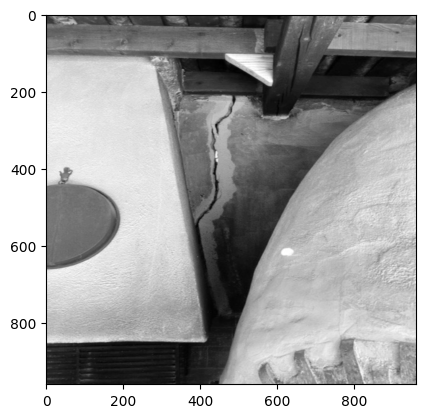

Label: 1


In [14]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0][0].squeeze()
label = train_labels[0]
plt.imshow(img,cmap='gray')
plt.show()
print(f"Label: {label}")

In [15]:
net = models.resnet18()

In [16]:
import torch.nn as nn
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 2)
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
# import torch.optim as optim
# from ignite.handlers.param_scheduler import create_lr_scheduler_with_warmup 

# total_iteration = 50
# warmup_iteration = 10
# initial_lr = 1e-3
# warmup_initial_lr = 1e-5

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=initial_lr, momentum=0.9)
# lr_scheduler = create_lr_scheduler_with_warmup(optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_iteration),
#                                                warmup_start_value=warmup_initial_lr,
#                                                warmup_duration=warmup_iteration,
#                                                warmup_end_value=initial_lr)

In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, verbose=True)

In [19]:
len(train_dataloader)

250

In [20]:
train_loss = []
test_loss = []

In [21]:
for epoch in range(50):  

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs = data[0].to(device)
        labels = data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
#         if i % 200 == 199: 
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
#             running_loss = 0
    print(f'epoch:{epoch+1} loss:{running_loss / len(train_dataloader)}')
    train_loss.append(running_loss/len(train_dataloader))
    scheduler.step(running_loss/len(train_dataloader))
    

# Validation of test set
    loss_test = 0
    with torch.no_grad():
        for data in test_dataloader:
            images = data[0].to(device)
            labels = data[1].to(device)
            output = net(images)
            loss = criterion(output, labels)
            loss_test += loss.item()
    test_loss.append(loss_test / len(test_dataloader))

    

print('Finished Training')

epoch:1 loss:0.6986175639629364
epoch:2 loss:0.7003140439987182
epoch:3 loss:0.6885489492416382
epoch:4 loss:0.6911096320152282
epoch:5 loss:0.7004551376104355
epoch:6 loss:0.6937221665382385
epoch:7 loss:0.695535921573639
epoch:8 loss:0.6935797924995423
epoch:9 loss:0.6881312744617463
epoch:10 loss:0.6971097468137741
epoch:11 loss:0.6924700815677642
epoch:12 loss:0.6948792926073074
epoch:13 loss:0.6757633049488068
epoch:14 loss:0.6843357169628144
epoch:15 loss:0.6731591128110885
epoch:16 loss:0.683803612947464
epoch:17 loss:0.6784367551803588
epoch:18 loss:0.6860724774599075
epoch:19 loss:0.6888667523860932
epoch:20 loss:0.6835804626941681
epoch:21 loss:0.6770399099588394
epoch:22 loss:0.6808272137641906
epoch:23 loss:0.6742740894556045
epoch:24 loss:0.6762998831272126
epoch:25 loss:0.6608892866373062
epoch:26 loss:0.6663204296827316
epoch:27 loss:0.6681215062141418
epoch:28 loss:0.6673520081043244
epoch:29 loss:0.6695147271156311
epoch:30 loss:0.6718877964019775
epoch:31 loss:0.66020

<function matplotlib.pyplot.show(close=None, block=None)>

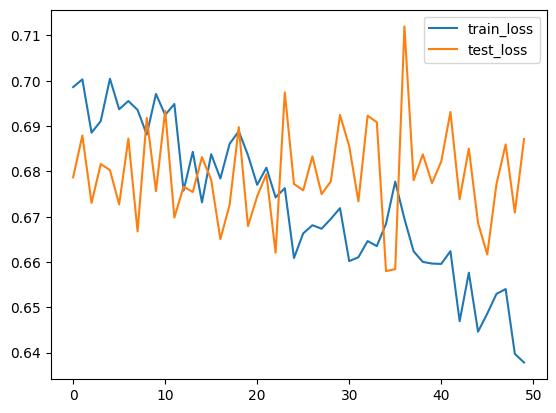

In [22]:
plt.plot(train_loss, label='train_loss')
plt.plot(test_loss, label='test_loss')
plt.legend()
plt.show

In [23]:
print(test_loss)

[0.6786802396658929, 0.6879316030010101, 0.6730404806233221, 0.6816358551863702, 0.6802941870785528, 0.6727212297339593, 0.6872358391842535, 0.6667590953650013, 0.6917918694596137, 0.675649925585716, 0.6933780257259646, 0.6698090580682601, 0.6766398948046469, 0.6754430967473215, 0.6831557298860242, 0.6781632388311047, 0.6650491815901571, 0.6725844142417754, 0.6897881007002246, 0.66792208124553, 0.6745208898378957, 0.6793684526797263, 0.6620492812606596, 0.6974321505235087, 0.6772204781732252, 0.6758311626411253, 0.6833165482647957, 0.6749988960162285, 0.6777752383101371, 0.6924675832833013, 0.6855768784880638, 0.6733883328495487, 0.6922969736399189, 0.6908648542819484, 0.6579910353306802, 0.6584490616956065, 0.7119905677053237, 0.678069381223571, 0.6837663402961146, 0.6773981906233295, 0.6821717002218769, 0.6931174423906111, 0.6738567015817089, 0.6850333259471001, 0.6686139065892466, 0.6616669191468146, 0.6771900742765395, 0.6859622439069133, 0.670926310843037, 0.6871504191189043]


In [24]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_dataloader:
        images = data[0].to(device)
        labels = data[1].to(device)
        images = images.to(torch.float)
        output = net(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the train images:{100 * correct / total}%')
print('Number of train images:',total)

Accuracy of the network on the train images:62.4248496993988%
Number of train images: 998


In [25]:
classes =('0','1')
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
correct = 0
total = 0

with torch.no_grad():
    for data in test_dataloader:
        images = data[0].to(device)
        labels = data[1].to(device)
        images = images.to(torch.float)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

print(f'Accuracy of the network on the test images:{100 * correct / total}%')
print('Number of train images:',total)

Accuracy for class: 0     is 47.7 %
Accuracy for class: 1     is 72.1 %
Accuracy of the network on the test images:59.22920892494929%
Number of train images: 493


In [26]:
PATH = './classification.pth'
torch.save(net.state_dict(), PATH)